In [1]:
"""
=======================================================================================
# This code runs with model.py, and process Video_16_3_2.mp4 with GT+Pred bounding box;
# Originally adapted in March, modified in Sep.
- Draw boxes
- Model deplyment
- Video Generation
LOG: Sep. 26th we're testing the baseline with EAST model, test it on ICDAR 2013
LOG: Oct. 7th reuse it on ICDAR 2015 to compare results 
=======================================================================================
"""
import cv2
import os
import time
import datetime
import numpy as np
import uuid
import json
import functools
import logging
import collections
import argparse
import matplotlib
matplotlib.use('Agg')
import tensorflow as tf

import _init_paths
from model import model
from utils.icdar import restore_rectangle
import lanms
from utils.eval import resize_image, sort_poly, detect
from utils.icdar import load_annotations_solo, check_and_validate_polys
from utils.nms_highlevel import intersection
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

/home/lxiaol9/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# used for iou searching and selecting TP, FP, FN #
def eval_single_frame(target, box):
    """
    input params:
        target, python ordered dict
        box, sorted boxes dict from predictions
    """
    TP   = 0
    FP   = 0
    FN   = 0
    precision = 0
    recall = 0
    F_measure = 0
    if not len(box['text_lines']) == 0:
        for t in target:
            d = np.array(t, dtype='int32')
            is_best = 0
            for m in box['text_lines']:
                n = np.array([m['x0'], m['y0'], m['x1'], m['y1'], m['x2'],
                              m['y2'], m['x3'], m['y3']], dtype='int32')

                # pick out the best match
                iou = intersection(n, d)
                if iou>is_best:
                    is_best = iou
            if is_best > 0.5:
                TP = TP+1
            elif is_best == 0:
                FN = FN +1
            else:
                FP = FP+1
        if TP > 0:
            precision = TP/(TP+FP)
            recall    = TP/(TP+FN)
            F_measure = 2*precision*recall/(precision+recall)
    return precision, recall, F_measure


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, thickness=2, color=(0, 0, 0))
    return illu


def draw_illu_gt(illu, rst, p, r, f):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.3
    fontColor = (255, 255, 255)
    lineType = 1
    infos = 'Precision ' + str(p)+ ', recall ' + str(r) + ', F_measure ' + str(f)
    cv2.putText(illu, infos,
                (2, 20),
                font,
                0.5,
                (255, 0, 0),
                lineType)
    for t in rst:
        d1 = t.reshape(-1, 2).astype(np.int32)
        cv2.polylines(illu, [d1], isClosed=True, thickness=2, color=(0, 0, 0))
        # bottomLeftCornerOfText = (int(t['x0']), int(t['y0']))

    return illu

In [3]:
print(cv2.__version__)

3.4.0


In [4]:
video_set = []
test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2015/test/'
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        if file.endswith('.mp4'):
            video_set.append(os.path.splitext(file)[0])
print(video_set)

['Video_39_2_3', 'Video_9_1_1', 'Video_22_5_1', 'Video_48_6_4', 'Video_30_2_3', 'Video_5_3_2', 'Video_17_3_1', 'Video_35_2_3', 'Video_6_3_2', 'Video_55_3_2', 'Video_34_2_3', 'Video_11_4_1', 'Video_20_5_1', 'Video_49_6_4', 'Video_15_4_1', 'Video_23_5_2', 'Video_43_6_4', 'Video_38_2_3', 'Video_44_6_4', 'Video_32_2_3', 'Video_53_7_4', 'Video_24_5_2', 'Video_50_7_4', 'Video_1_1_2']


resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
INFO:tensorflow:Restoring parameters from /work/cascades/lxiaol9/ARC/EAST/checkpoints/east/20180921-135717/model.ckpt-56092
Processing 70 frame for Video_6_3_2 video with  (480, 720, 3)
103 text boxes before nms, 7 text boxes after nms


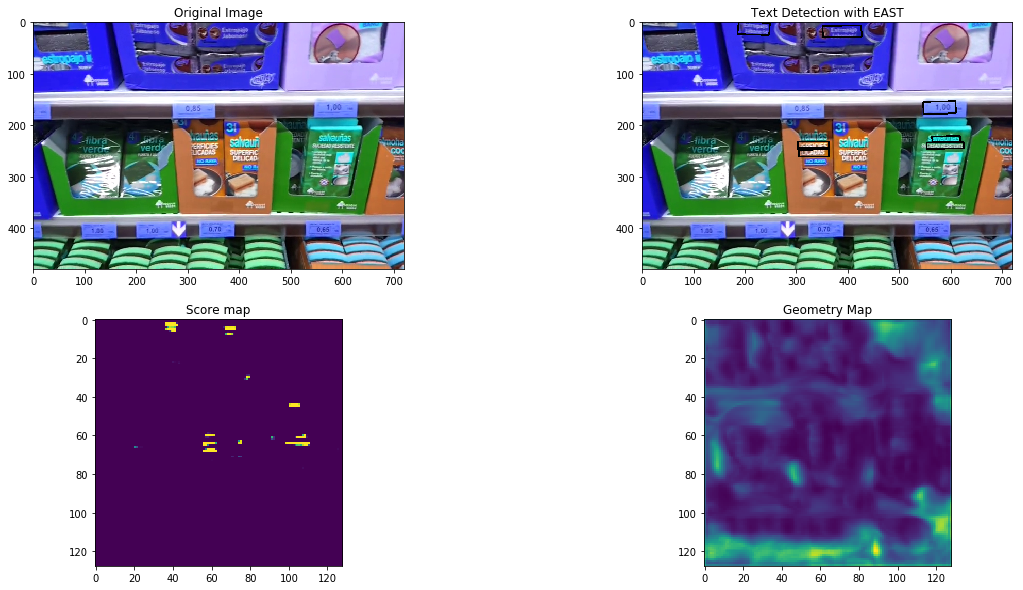

Processing 71 frame for Video_6_3_2 video with  (480, 720, 3)
165 text boxes before nms, 13 text boxes after nms


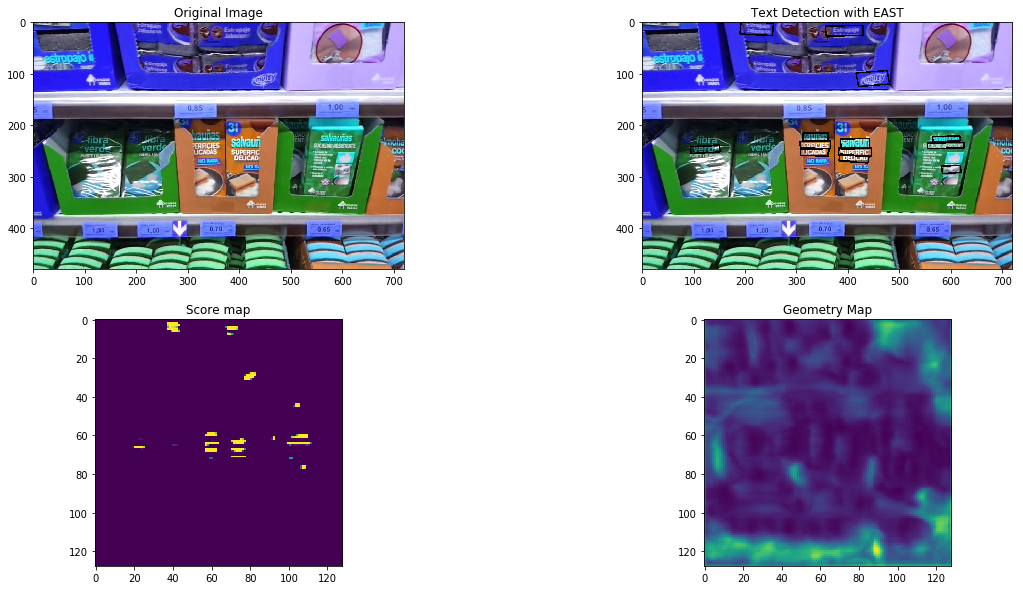

Processing 72 frame for Video_6_3_2 video with  (480, 720, 3)
200 text boxes before nms, 17 text boxes after nms


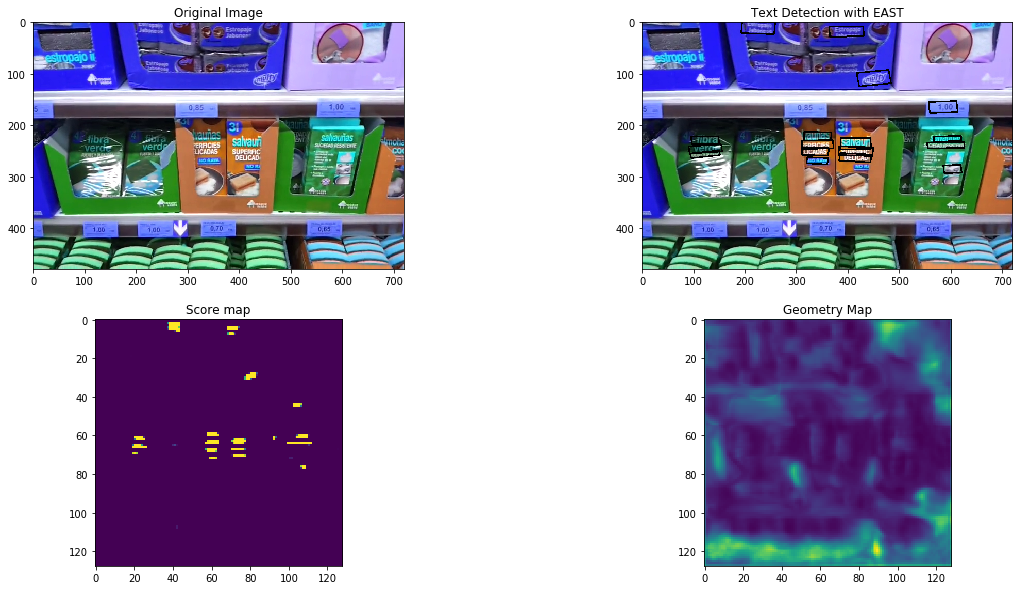

Processing 73 frame for Video_6_3_2 video with  (480, 720, 3)
143 text boxes before nms, 9 text boxes after nms


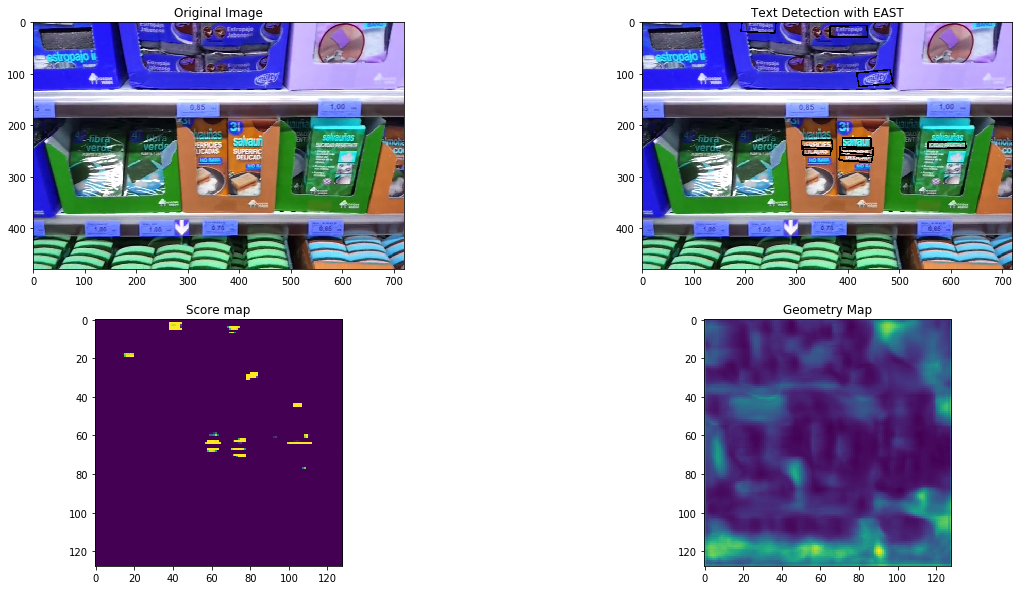

Processing 74 frame for Video_6_3_2 video with  (480, 720, 3)
81 text boxes before nms, 5 text boxes after nms


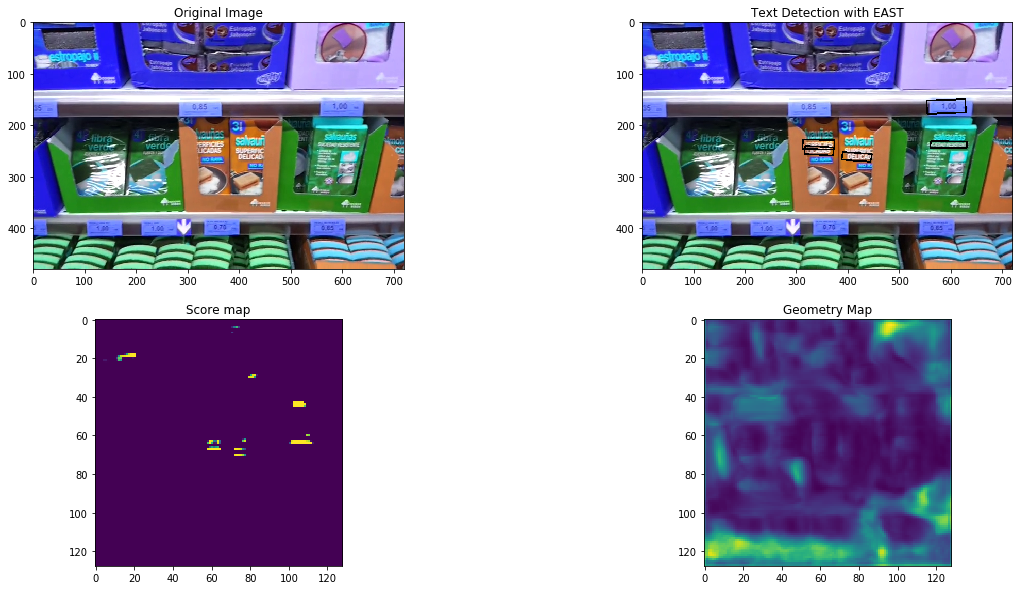

Processing 75 frame for Video_6_3_2 video with  (480, 720, 3)
118 text boxes before nms, 8 text boxes after nms


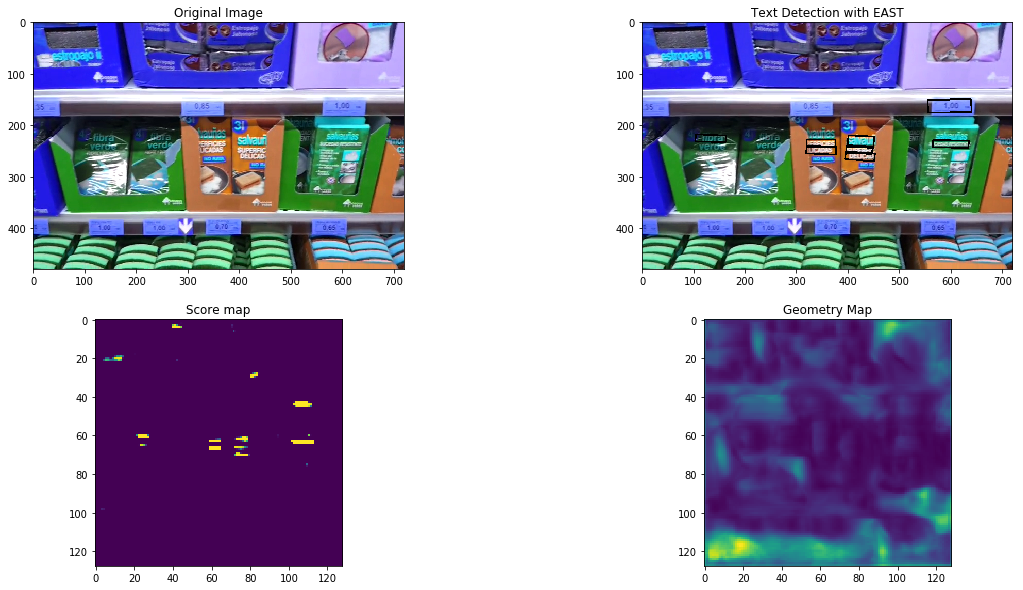

Processing 76 frame for Video_6_3_2 video with  (480, 720, 3)
100 text boxes before nms, 8 text boxes after nms


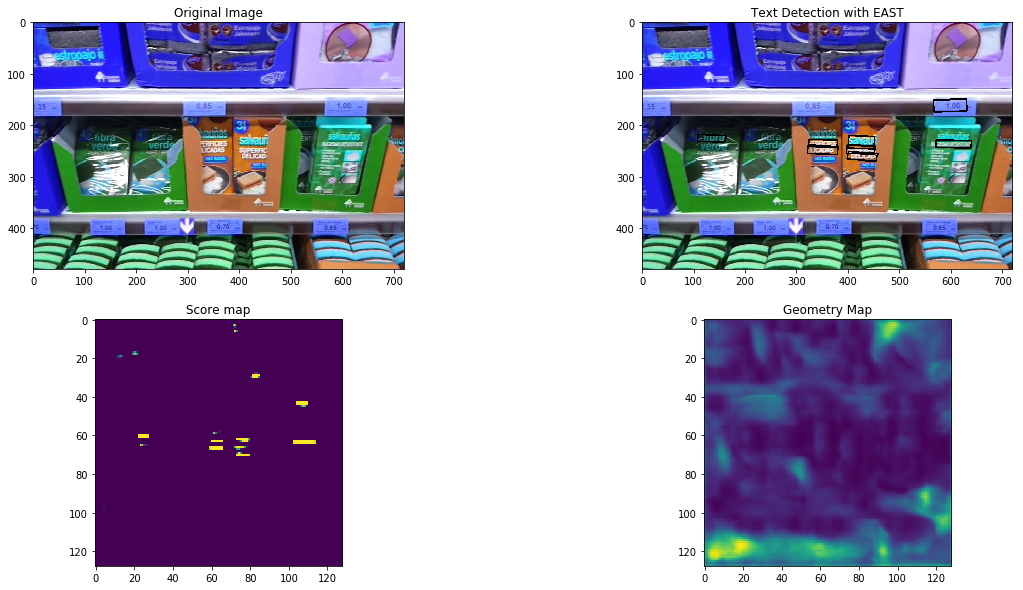

Processing 77 frame for Video_6_3_2 video with  (480, 720, 3)
80 text boxes before nms, 6 text boxes after nms


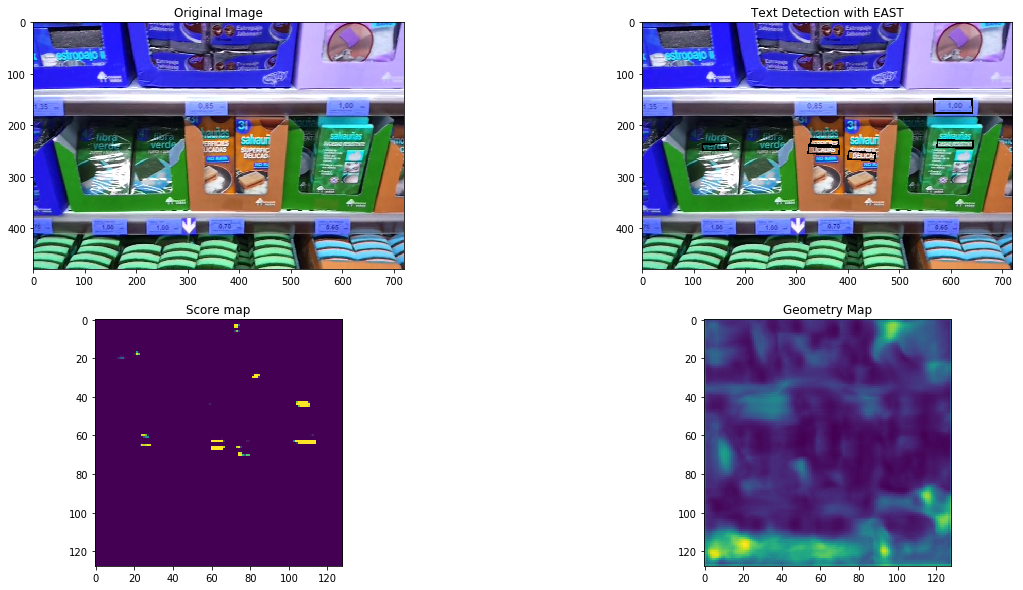

Processing 78 frame for Video_6_3_2 video with  (480, 720, 3)
73 text boxes before nms, 5 text boxes after nms


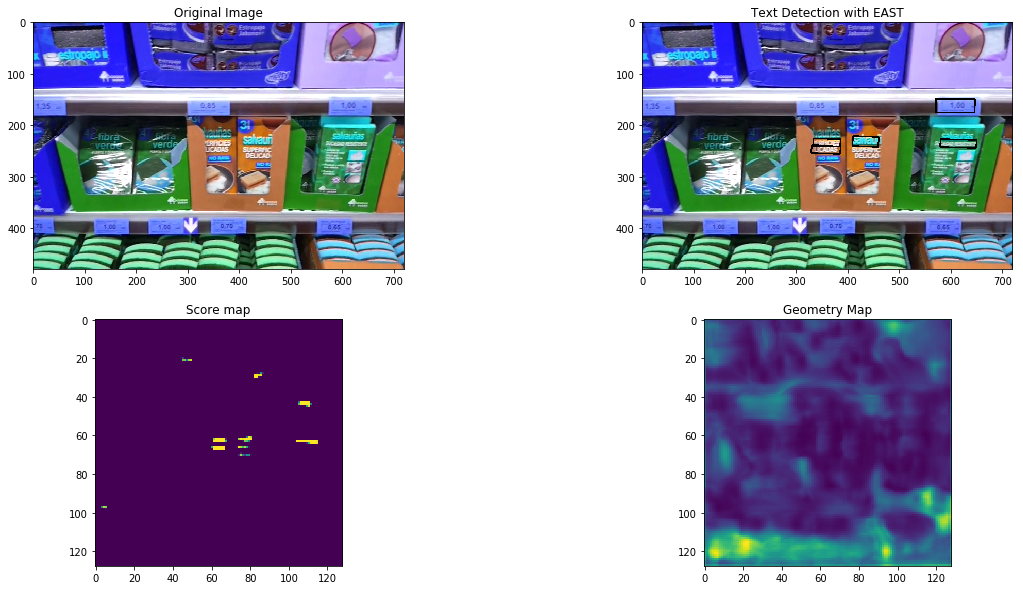

Processing 79 frame for Video_6_3_2 video with  (480, 720, 3)
107 text boxes before nms, 9 text boxes after nms


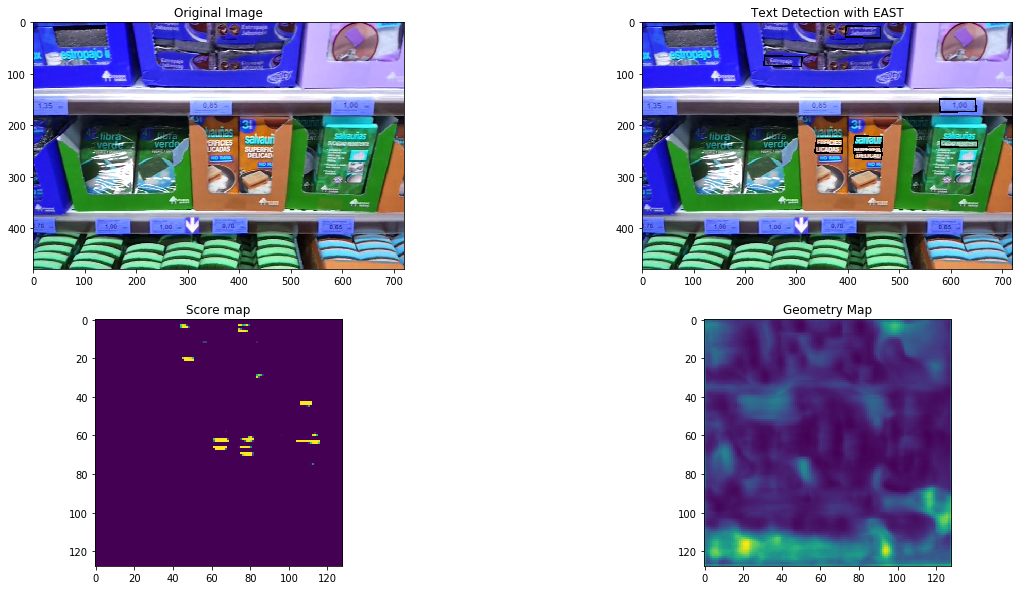

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
testing results are P:0.0, R:0.0, F1:0.0 on Video_6_3_2
here is the precision
0.0
here is the recall
0.0
here is the f-score
0.0
['Video_39_2_3', 'Video_9_1_1', 'Video_22_5_1', 'Video_48_6_4', 'Video_30_2_3', 'Video_5_3_2', 'Video_17_3_1', 'Video_35_2_3', 'Video_6_3_2', 'Video_55_3_2', 'Video_34_2_3', 'Video_11_4_1', 'Video_20_5_1', 'Video_49_6_4', 'Video_15_4_1', 'Video_23_5_2', 'Video_43_6_4', 'Video_38_2_3', 'Video_44_6_4', 'Video_32_2_3', 'Video_53_7_4', 'Video_24_5_2', 'Video_50_7_4', 'Video_1_1_2']


In [5]:
%matplotlib inline
def main():
    #>>>>>>>>>>>>>>>>>>>>>   1. define data/model path      >>>>>>>>>>>>>>>>>>>>>#
    test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2015/test/'
    save_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2015/test_results/'
    checkpoint_path = '/work/cascades/lxiaol9/ARC/EAST/checkpoints/east/'
    idname1 = '20180921-135717'
    idname2 = 'model.ckpt-56092'
    index = [8]
    vis_flag = True
    idx = 0  # initial frame number
    if not os.path.exists(checkpoint_path):
        raise RuntimeError(
            'Checkpoint `{}` not found'.format(checkpoint_path))
    logger.info('loading model')
    #>>>>>>>>>>>>>>>>>>>>>>>   2. Loading Model        >>>>>>>>>>>>>>>>>>>>>>>>>#
    gpu_options = tf.GPUOptions(allow_growth=True)
    input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
    global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
    f_score, f_geometry, _ = model.model(input_images, is_training=False)
    variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
    saver = tf.train.Saver(variable_averages.variables_to_restore())
    #>>>>>>>>>>>>>>>>>>>>>>>>  3. restore the model from weights  >>>>>>>>>>>>>#
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    model_path = checkpoint_path + idname1 + '/' + idname2
    logger.info('Restore from {}'.format(model_path))
    saver.restore(sess, model_path)
    #>>>>>>>>>>>>>>>>>>>>>>    3. Start evaluation      >>>>>>>>>>>>>>>>>>>>>>>>>#
    P_test = []
    R_test = []
    f1_test = []
    for k in index:
        P_video = []
        R_video = []
        f1_video = []
        video_save = save_path + video_set[k] + idname1 + '_' + idname2 + '.avi'
        t_start = time.time()
        xml_solo_path = test_data_path + video_set[k]
        raw_video_path = test_data_path + video_set[k]+'.mp4'
        cap = cv2.VideoCapture(raw_video_path)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        cnt_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out = cv2.VideoWriter(video_save, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        # 1. load both polys and tags; 2. generate geo maps(the format of polys and tags need to match)
        # polys_array_list, tags_array_list, id_list_list, frame_num = load_annotations_solo(xml_solo_path, \
        #             1, cnt_frame, frame_width, frame_height)
        #>>>>>>>>>>>>>>>>>>>>>>>>   4. loop over frames     >>>>>>>>>>>>>>>>>>#
        for m in range(7*10, (7+1)*10):
            cap.set(1, m)
            ret, frame = cap.read()
            # text_polys, text_tags = load_annoataion(txt_fn)
            # text_polys, text_tags = polys_array_list[m], tags_array_list[m]
            # text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (frame_height, frame_width))
            #     # im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=False)
            # if text_polys.shape[0] == 0:
            #     continue
            if ret == True:
                print('Processing %d frame for %s video with '%(m, video_set[k]), frame.shape)
                start_time = time.time()
                img = frame
                rtparams = collections.OrderedDict()
                rtparams['start_time'] = datetime.datetime.now().isoformat()
                rtparams['image_size'] = '{}x{}'.format(img.shape[1], img.shape[0])
                timer = collections.OrderedDict([
                    ('net', 0),
                    ('restore', 0),
                    ('nms', 0)
                ])
                # im_resized, (ratio_h, ratio_w) = resize_image(img)
                im_resized = cv2.resize(frame, (int(512), int(512)))
                ratio_h, ratio_w = 512/frame_height, 512/frame_width
                rtparams['working_size'] = '{}x{}'.format(
                    im_resized.shape[1], im_resized.shape[0])
                start = time.time()
                score, geometry = sess.run(
                    [f_score, f_geometry],
                    feed_dict={input_images: [im_resized[:,:,::-1]]})
                timer['net'] = time.time() - start
                boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
                logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
                    timer['net']*1000, timer['restore']*1000, timer['nms']*1000))
                if boxes is not None:
                    scores = boxes[:,8].reshape(-1)
                    boxes = boxes[:, :8].reshape((-1, 4, 2))
                    boxes[:, :, 0] /= ratio_w
                    boxes[:, :, 1] /= ratio_h
                duration = time.time() - start_time
                timer['overall'] = duration
                logger.info('[timing] {}'.format(duration))
                text_lines = []
                if boxes is not None:
                    text_lines = []
                    for box, score_new in zip(boxes, scores):
                        box = sort_poly(box.astype(np.int32))
                        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                            continue
                        tl = collections.OrderedDict(zip(
                            ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                            map(float, box.flatten())))
                        tl['score'] = float(score_new)
                        text_lines.append(tl)
                pred = {
                    'text_lines': text_lines,
                    'rtparams': rtparams,
                    'timing': timer,
                }
                new_img = draw_illu(img.copy(), pred)
                out.write(new_img)
                #>>>>>>>>>>>>>>>>>>>>>>>>  5. Run Visualization & Save  >>>>>>>>>>>>>>>>>>>>>>#
                # targets = text_polys
                # precision, recall, f1 = eval_single_frame(targets, pred)
                precision, recall, f1 = 0, 0, 0
                P_video.append(precision)
                R_video.append(recall)
                f1_video.append(f1)
                # new_img1 = draw_illu_gt(new_img.copy(), targets, precision, recall, f1)
                if vis_flag:
#                     import pdb; pdb.set_trace()
                    fig1 = plt.figure(figsize=(20, 10))
                    fig1.add_subplot(2, 2, 1)
                    plt.imshow(img)
                    plt.title("Original Image")
                    fig1.add_subplot(2, 2, 2)
                    plt.imshow(new_img)
                    plt.title('Text Detection with EAST')
                    fig1.add_subplot(2, 2, 3)
                    plt.imshow((np.squeeze(score*255)).astype(np.uint8))
                    plt.title('Score map')
                    fig1.add_subplot(2, 2, 4)
                    plt.imshow(geometry[0, :,:,1])
                    plt.title('Geometry Map')                    
                    plt.show()
                    fig1.savefig(save_path+"frame" + str(m) + ".png", dpi=500)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
                # time.sleep(.100)
            else:
                break
            # evaluation on ret and gt
        P_test.append(np.array(P_video, dtype=np.float32))
        R_test.append(np.array(R_video, dtype=np.float32))
        f1_test.append(np.array(f1_video, dtype=np.float32))
        print(P_video)
        print(R_video)
        print(f1_video)
        print("testing results are P:{}, R:{}, F1:{} on ".format(sum(P_video)/cnt_frame, sum(R_video)/cnt_frame, sum(f1_video)/cnt_frame)+video_set[k])
        cap.release()
        out.release()
        cv2.destroyAllWindows()
    print('here is the precision')
    for item in P_test:
        print(np.mean(item))
    print('here is the recall')
    for item in R_test:
        print(np.mean(item))
    print('here is the f-score')
    for item in f1_test:
        print(np.mean(item))
    print(video_set)
if __name__ == '__main__':
    main()